In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mping
from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib.pyplot import imread, imshow
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.utils import shuffle


/tmp/ipykernel_14313/3831151401.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
import os
module_path = '/home/srikanth/Downloads/going_modular/'
sys.path.append(os.path.dirname(module_path))

In [3]:
root_path = r"/home/srikanth/Dataset/RGB_images"
dataset_path = os.listdir(root_path)

In [4]:
!python --version

/bin/bash: line 1: python: command not found


In [5]:
import torch
torch.__version__

'2.0.0+cu118'

In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Create Datasets and DataLoaders

In [8]:
class_labels = []

for item in dataset_path:
    #print(item)
    all_objects = os.listdir(root_path + '/' +item)
    for top_object in all_objects:
        sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
        for sub_object in sub_objects:
            images = os.listdir(root_path + '/' +item + '/' +top_object + '/' +sub_object)
            for image in images:
                class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object +'/' +image)))

df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
y=list(df['labels'].values)
image=df['image']

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
images, y= shuffle(image,y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.1, random_state=415)
test_x = test_x.reset_index(drop=True)
train_x = train_x.reset_index(drop=True)
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y, test_size=0.1, random_state=415)
train_x = train_x.reset_index(drop=True)
train_y=list(train_y)
train_df=pd.DataFrame({'filepaths':train_x,'labels':train_y})
valid_df=pd.DataFrame({'filepaths':val_x,'labels':val_y})
test_df=pd.DataFrame({'filepaths':test_x,'labels':test_y})




In [9]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [10]:
from PIL import Image
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])
        self.label_mapping = label2id

    def __len__(self):
        return len(self.df)

    def get_images(self, idx):
      return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
      label = self.df.iloc[idx]['labels']
      return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels



In [11]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_df,
    test_df,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = ImageDataset(train_df)
  test_data = ImageDataset(test_df)

  # Get class names
  class_names = list(train_df['labels'].unique())

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      #pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      #pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [12]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_df=train_df,
    test_df=test_df,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fcd02bb2530>,
 ['Tripod', 'Palmar wrist neutral', 'Pinch', 'Palmar wrist pronated'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224]) tensor(1)


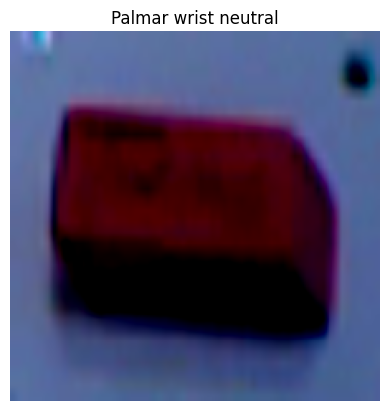

In [13]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [14]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
print(class_names)

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output


['Tripod', 'Palmar wrist neutral', 'Pinch', 'Palmar wrist pronated']


In [15]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable


In [16]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [17]:

# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


# Let's build a vision transformer

# Train Model

In [18]:
import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
pretrained_vit_results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

/home/srikanth/graspenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 10%|████                                     | 1/10 [15:32<2:19:55, 932.79s/it]

Epoch: 1 | train_loss: 0.4454 | train_acc: 0.8763 | test_loss: 0.4455 | test_acc: 0.8820


 20%|████████▏                                | 2/10 [31:20<2:05:31, 941.41s/it]

Epoch: 2 | train_loss: 0.4441 | train_acc: 0.8772 | test_loss: 0.4580 | test_acc: 0.8656


 30%|████████████                            | 3/10 [49:10<1:56:42, 1000.30s/it]

Epoch: 3 | train_loss: 0.4435 | train_acc: 0.8781 | test_loss: 0.4789 | test_acc: 0.8535


 40%|███████████████▏                      | 4/10 [1:10:36<1:51:17, 1112.93s/it]

Epoch: 4 | train_loss: 0.4438 | train_acc: 0.8772 | test_loss: 0.4451 | test_acc: 0.8546


 50%|███████████████████                   | 5/10 [1:32:02<1:37:57, 1175.60s/it]

Epoch: 5 | train_loss: 0.4435 | train_acc: 0.8776 | test_loss: 0.4242 | test_acc: 0.8815


 60%|██████████████████████▊               | 6/10 [1:53:35<1:21:01, 1215.37s/it]

Epoch: 6 | train_loss: 0.4427 | train_acc: 0.8780 | test_loss: 0.4873 | test_acc: 0.8378


 70%|████████████████████████████            | 7/10 [2:11:25<58:23, 1167.95s/it]

Epoch: 7 | train_loss: 0.4441 | train_acc: 0.8770 | test_loss: 0.4451 | test_acc: 0.8706


 80%|████████████████████████████████        | 8/10 [2:29:15<37:53, 1136.72s/it]

Epoch: 8 | train_loss: 0.4433 | train_acc: 0.8775 | test_loss: 0.4303 | test_acc: 0.8742


 90%|████████████████████████████████████    | 9/10 [2:47:08<18:36, 1116.87s/it]

Epoch: 9 | train_loss: 0.4442 | train_acc: 0.8777 | test_loss: 0.4338 | test_acc: 0.8847


100%|███████████████████████████████████████| 10/10 [3:05:16<00:00, 1111.68s/it]

Epoch: 10 | train_loss: 0.4431 | train_acc: 0.8775 | test_loss: 0.4456 | test_acc: 0.8888


Our ViT model has come to life!

Results on our custom dataset don't look too good.

Lets plot the accuracy and loss curves

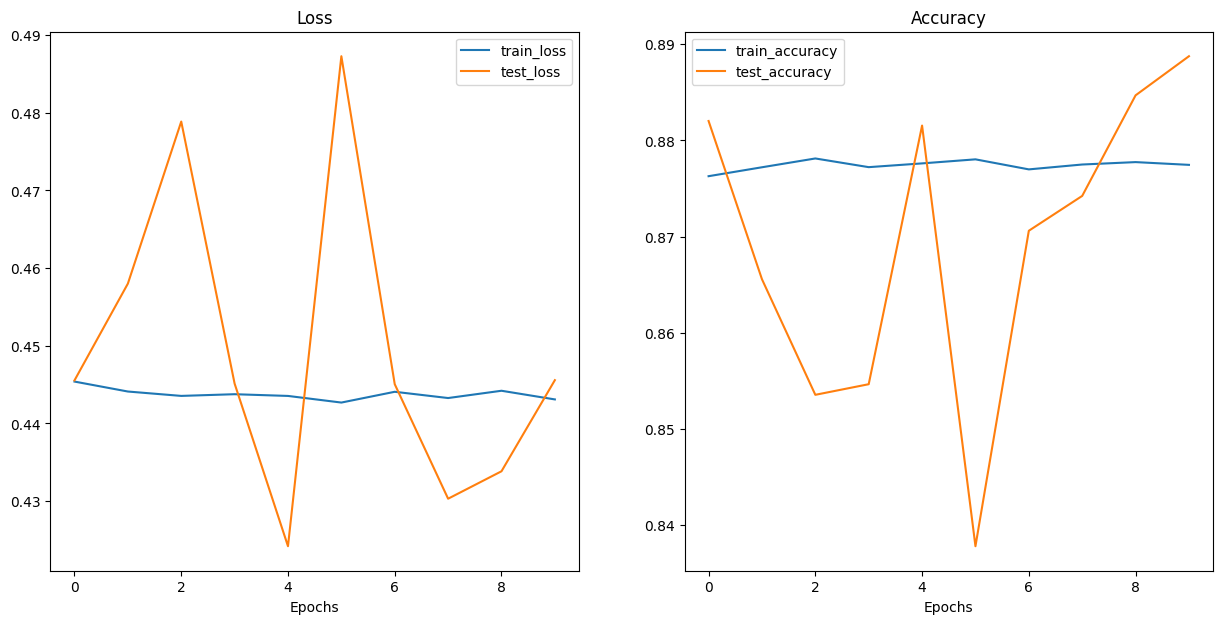

In [19]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(pretrained_vit_results)

In [23]:
torch.save(pretrained_vit.state_dict(), r"/home/srikanth/Downloads/WWC results/vit_model_feb29.pt")

# Predictions

In [ ]:

import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_img.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
from tqdm import tqdm
import time

# Create a sample list for demonstration
my_list = list(range(10))

# Wrap the iterable with tqdm for progress bar
for i, item in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Processing"):
    # Simulate some work being done
    

    # Your code here...
    # In this example, we are just printing the index and item


# The progress bar will be automatically closed when the loop completes
